### Goals

The idea here is to make a set of data as close as possible to what we're planning to use for hyperspectral. A lot is going to change inevitably, but having data as close to what we're planning will allow for a much better basic pipeline to rely on when we actually move to production

In [130]:
!pip install opencv-python

import cv2
import os
import re
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

# Quick function to convert our tif files to an AVI to imitate our future plans

def tif_to_avi(tif_folder, output_avi_path):
    # Get all the tif files in the folder
    tif_files = [f for f in os.listdir(tif_folder) if f.endswith('.tif')]

    # Sort the files numerically using regular expressions
    tif_files.sort(key=lambda x: int(re.findall('\d+', x)[0]))

    # Read the first file to get image dimensions
    first_tif = cv2.imread(os.path.join(tif_folder, tif_files[0]), cv2.IMREAD_GRAYSCALE)
    height, width = first_tif.shape

    # Create the video writer object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    video_writer = cv2.VideoWriter(output_avi_path, fourcc, 30.0, (width, height), isColor=False)

    # Loop through the tif files and add them to the video
    for tif_file in tif_files:
        tif_path = os.path.join(tif_folder, tif_file)
        frame = cv2.imread(tif_path, cv2.IMREAD_GRAYSCALE)
        video_writer.write(frame)

    # Release the video writer
    video_writer.release()

    

In [44]:
# tif_to_avi('100fps_80px/', './80px.avi')

Init signature: cv2.VideoWriter(self, /, *args, **kwargs)
Docstring:      <no docstring>
File:           /opt/conda/lib/python3.10/site-packages/cv2/__init__.py
Type:           type
Subclasses:     

In [39]:
import cv2
import numpy as np

# Load an AVI to a numpy array
def avi_to_3d_array(avi_path):
    # Open the video file
    cap = cv2.VideoCapture(avi_path)

    # Get the dimensions of the frames
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Initialize the numpy array
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    arr = np.zeros((num_frames, height, width, 3), dtype=np.uint8)

    # Loop through the frames and add them to the numpy array
    for i in range(num_frames):
        ret, frame = cap.read()
        if ret:
            arr[i] = frame

    # Release the video capture object
    cap.release()

    return arr


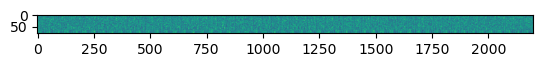

In [125]:
# Loads the data, ditches the redundant color dimension assumed from the AVI, reshapes it to be X,Y,channels

input_data = avi_to_3d_array('./80px.avi')[:,:,:,0].reshape(80, 2200, 256)
plt.imshow(input_data[:,:,0])


In [126]:
input_data.min(), input_data.max(), input_data.mean(), input_data.std()

(0, 255, 75.11859556995739, 69.39848335772801)

In [124]:
tif_folder = '100fps_80px/'
output_avi_path = './80px.avi'

# Get all the tif files in the folder
tif_files = [f for f in os.listdir(tif_folder) if f.endswith('.tif')]

# Sort the files numerically using regular expressions
tif_files.sort(key=lambda x: int(re.findall('\d+', x)[0]))

# Read the first file to get image dimensions
first_tif = cv2.imread(os.path.join(tif_folder, tif_files[0]), cv2.IMREAD_UNCHANGED)
height, width = first_tif.shape

# Create the video writer object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(output_avi_path,
                               fourcc, 30.0,
                               (width, height),
                               isColor=False)

# Loop through the tif files and add them to the video
for tif_file in tif_files:
    tif_path = os.path.join(tif_folder, tif_file)
    frame = cv2.imread(tif_path, cv2.IMREAD_UNCHANGED)
    video_writer.write(frame)

# Release the video writer
video_writer.release()

### Notes

So, Python's OpenCV package is doing a *lot* to the data it's not talking about. When you load an image using OpenCV's imread function it's adding a typical RGB dimension to these .tif files that doesn't exist. It's replicating the current image 3 times in order to do that, so it's not very efficient either. 

OpenCV *also* is converting natively to a different datatype, and collapsing the actual tif values into a range of 1-256. We really don't want it doing that. 

This can be fixed be appending cv2.IMREAD_ANYDEPTH to the `imread` function, or cv2.IMREAD_ANYCOLOR, but to do both we need cv2.IMREAD_UNCHANGED. It's worth noting that the `imread` function in Matplotlib's PyPlot just returns the data natively. Okay, onwards. 

In [128]:
# Functions to use

# Functions we'll use

def fetch_image_data(image_path: str, 
                     show_image: bool = True) -> np.ndarray:
    """
    Reads an image file from the given path using Pillow, and returns it as a NumPy array.
    Optionally, displays the image using Matplotlib.

    Args:
        image_path (str): Path to the image file.
        show_image (bool): Whether to display the image using Matplotlib. Default is True.

    Returns:
        np.ndarray: A NumPy array representing the image.

    Raises:
        FileNotFoundError: If the specified image file does not exist.
        ValueError: If the specified image file is not a valid image file or could not be read.

    """

    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"{image_path} not found")
    try:
        with Image.open(image_path) as image:
            example_image = plt.imread(image_path)
            if show_image:
                plt.figure()
                plt.imshow(example_image)
                plt.title('Image display of: ' + image_path)
            return example_image
    except Exception as e:
        raise ValueError(f"Could not read {image_path}: {str(e)}")


In [333]:
# Calibration system will need to take a set of inputs

# First let's make a calibration that's a little bit more accurate

# Collect and display all the image data we're currently interested in 
curr_image = fetch_image_data('hvc 2197.tif', show_image=False)

white_ref = fetch_image_data('calibration_data/spectralon 0.15ms.tif', show_image=False)
dark_ref = fetch_image_data('calibration_data/dark 0.15ms.tif', show_image=False)
wavelength_ref = fetch_image_data('calibration_data/avian_wavelength_cal.tif', show_image=False)

# # Do the same for CSV data
# ref_5_df = pd.read_csv('calibration_data/fake_ref_5.csv', header = None)
# ref_20_df = pd.read_csv('calibration_data/fake_ref_20.csv', header = None)
# ref_80_df = pd.read_csv('calibration_data/fake_ref_80.csv', header = None)
# ref_99_df = pd.read_csv('calibration_data/fake_ref_99.csv', header = None)

n_bands = 256
curr_imsize = curr_image.shape
curr_image = curr_image.reshape(80, n_bands)

n_pixels = curr_image.shape[0]

white_ref_subset = white_ref.reshape(320, n_bands)[0:n_pixels, :]
dark_ref_subset = dark_ref.reshape(320, n_bands)[0:n_pixels, :]

# Add some random noise to the white ref
zero_mat = np.zeros_like(white_ref_subset)
# zero_mat + np.random
noise_mat = zero_mat + np.random.normal(0, 
                                        0.05,
                                        size = zero_mat.shape)

ref05 = (white_ref_subset * 0.05)
# Add 5% random Gaussian noise
ref05 = ref05 + (ref05 * noise_mat)

ref20 = white_ref_subset * 0.50
ref20 = ref20 + (ref20 * noise_mat)

ref80 = white_ref_subset * 0.86
ref80 = ref80 + (ref80 * noise_mat)

ref99 = white_ref_subset * 1
# ref99 = ref99 + (ref99 * noise_mat)

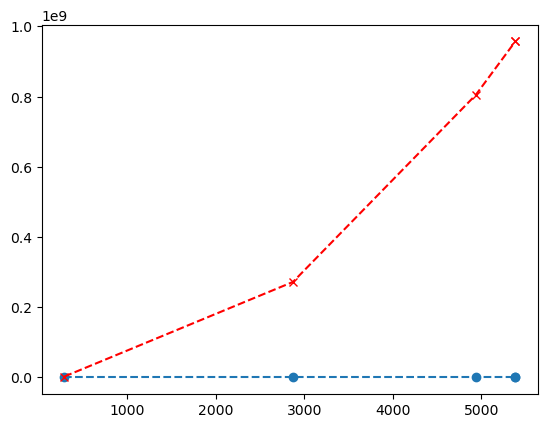

In [339]:
# plt.plot([dark_ref_subset[0,100], white_ref_subset[0, 100]], [0, 100])

# def simulate_data(original_data, a, b, c, percentile):
#     x = np.percentile(original_data, percentile)
#     y = a + b * x + c * x**2
#     return y

# for percentile in [5, 20, 80, 99]:
#     a, b, c = generate_coefficients()
#     simulated_value = simulate_data(original_data, a, b, c, percentile)
#     print(f"Simulated value at {percentile}%: {simulated_value}")

# Fit a quadratic equation to a data subset we generated
curr_pix = 0
curr_wav = 0

curr_test = np.asarray([ref05[curr_pix, curr_wav], 
                        ref20[curr_pix, curr_wav], 
                        ref80[curr_pix, curr_wav], 
                        ref99[curr_pix, curr_wav], 
                        white_ref_subset[curr_pix, curr_wav]])

a_fit, b_fit, c_fit = np.polynomial.Polynomial.fit(curr_test,
                                 [5, 20, 80, 99, 100],
                                 2)

# Gen the last intermediate data from these coefficients


def return_y(x, a_fit = a_fit, b_fit = b_fit, c_fit = c_fit):
    y = a_fit + b_fit * x + c_fit * x**2
    return y

return_y(curr_test)

plt.plot(curr_test, [5,20,80,99,100], 'o--')
plt.plot(curr_test, return_y(curr_test), 'rx--')

